## Runnning with gammapy-dev/IRF_model
Fitting asimov datasets with nuisance parameters based on the different livetimes

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
import Dataset_load 

from  Dataset_Setup import Setup, GaussianCovariance_matrix

## Read dataset

In [2]:
c = Dataset_load.load_config()
awo, aw, ewo, ew = c['_colors']  

In [3]:
livetimes = c['livetimes']
zero = c['zero'] 
norm = c['norm'] 
tilt = c['tilt'] 
bias = c['bias'] 
resolution = c['resolution'] 
magnitude = c['magnitude'] 
corrlength = c['corrlength']
sys = c['sys'] 
folder = c['folder']
nbidx = 0


In [4]:
%%time
datasets_input = []
for l in livetimes:
    datasets_i  = Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                                   livetime = f"{l}-hr",
                                            parameters = None)
    datasets_input.append(datasets_i)

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-0.01-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-0.021544346900318832-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-0.046415888336127774-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-0.1-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-0.21544346900318834-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-0.46415888336127775-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-1.0-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simula

## Datasets

In [5]:
def set_up(dataset_input):
    
    setup = Setup(dataset_input=dataset_input)
    #setup.set_up_irf_sys(bias, resolution, norm, tilt)
    dataset_asimov, dataset_asimov_N = setup.run()
    # irf model
    setup.set_irf_model(dataset_asimov_N)
    if sys == "Eff_area":
        dataset_asimov_N.models.parameters['resolution'].frozen = True
        dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
        dataset_asimov_N.irf_model.parameters['bias'].frozen = True
        setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)

    # piece wise model
    # remove old bkg model
    #setup.unset_model(dataset_asimov_N, FoVBackgroundModel)
    #setup.set_piecewise_bkg_model(dataset_asimov_N)
    # energy of the following parameters smaller than ethrshold
    #dataset_asimov_N.background_model.parameters['norm0'].frozen = True
    #dataset_asimov_N.background_model.parameters['norm1'].frozen = True
    #dataset_asimov_N.background_model.parameters['norm2'].frozen = True
    #dataset_asimov_N.background_model.parameters['norm3'].frozen = True
    #setup.set_bkg_prior(dataset_asimov_N, magnitude, corrlength)

    
       
    return dataset_asimov_N, dataset_asimov

In [6]:
datasets_N = []
datasets = []
for d in datasets_input:
    dataset_asimov_N, dataset_asimov = set_up(d)
    datasets_N.append(dataset_asimov_N)
    datasets.append(dataset_asimov)

In [7]:
%%time
fitting = 0
if fitting:
    for i, d in enumerate(datasets):
        print(i)
        fit_cor = Fit(store_trace=0)
        result_cor = fit_cor.run(d)
        print(result_cor)
        print("saving")
        path = f'../{folder}/data/0_model_livetime_{livetimes[i]}.yml'
        d.models.write(path,overwrite=True)
    
else:
    print("read")
    for i, d in enumerate(datasets):
        print(i)
        path = f'../{folder}/data/0_model_livetime_{livetimes[i]}.yml'
        datasets[i].models = Models.read(path)


read
0
1
2
3
4
5
6
7
8
9
10
11
12
CPU times: user 276 ms, sys: 7.59 ms, total: 283 ms
Wall time: 299 ms


In [9]:
%%time
fitting_N = 0

if fitting_N:
    
    for i, d in enumerate(datasets_N):
        print(i)
        fit_cor = Fit(store_trace=0)
        result_cor = fit_cor.run(d)
        print(result_cor)
        print("saving")
        path = f'../{folder}/data/0_model_nui_livetime_{livetimes[i]}.yml'
        d.models.write(path,overwrite=True)
    
else:
    print("read")
    for i, d in enumerate(datasets_N):
        print(i)
        path = f'../{folder}/data/0_model_nui_livetime_{livetimes[i]}.yml'
        print(path)
        datasets_N[i] = Dataset_load.load_dataset_N(d, path,bkg_sys = False)        
        datasets_N[i].models.parameters['tilt'].frozen = False 
    

#39min 32

read
0
../Eff_area_PKSflare_crab_break/data/0_model_nui_livetime_0.01.yml
1
../Eff_area_PKSflare_crab_break/data/0_model_nui_livetime_0.021544346900318832.yml
2
../Eff_area_PKSflare_crab_break/data/0_model_nui_livetime_0.046415888336127774.yml
3
../Eff_area_PKSflare_crab_break/data/0_model_nui_livetime_0.1.yml
4
../Eff_area_PKSflare_crab_break/data/0_model_nui_livetime_0.21544346900318834.yml
5
../Eff_area_PKSflare_crab_break/data/0_model_nui_livetime_0.46415888336127775.yml
6
../Eff_area_PKSflare_crab_break/data/0_model_nui_livetime_1.0.yml
7
../Eff_area_PKSflare_crab_break/data/0_model_nui_livetime_2.154434690031884.yml
8
../Eff_area_PKSflare_crab_break/data/0_model_nui_livetime_4.641588833612778.yml
9
../Eff_area_PKSflare_crab_break/data/0_model_nui_livetime_10.0.yml
10
../Eff_area_PKSflare_crab_break/data/0_model_nui_livetime_21.544346900318832.yml
11
../Eff_area_PKSflare_crab_break/data/0_model_nui_livetime_46.41588833612777.yml
12
../Eff_area_PKSflare_crab_break/data/0_model_nui_

In [10]:
labels = [str(int(l)) for l in livetimes]
models_list = [ d.irf_model for d in datasets_N]
pars =   [('bias', 'resolution'), ('norm', 'tilt')]

colors_default =  plt.rcParams['axes.prop_cycle'].by_key()['color'] 
colors_default = colors_default* 5

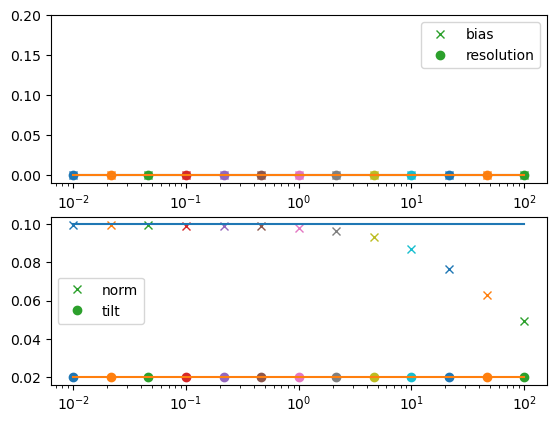

In [11]:
i = 0
fig,axs = plt.subplots(2,1)
for l, m in zip(livetimes, models_list):
    axs[0].plot(l, m.parameters[pars[0][0]].error, 'x', label = "bias", color = colors_default[i])
    axs[0].plot(l, m.parameters[pars[0][1]].error, 'o' , label = "resolution", color = colors_default[i])
    axs[1].plot(l, m.parameters[pars[1][0]].error, 'x' , label = "norm", color = colors_default[i])
    axs[1].plot(l, m.parameters[pars[1][1]].error, 'o' , label = "tilt", color = colors_default[i])
    i +=1
    
    
axs[0].plot([livetimes[0],livetimes[-1]], [bias, bias])
axs[0].plot([livetimes[0],livetimes[-1]], [resolution, resolution])
axs[1].plot([livetimes[0],livetimes[-1]], [norm, norm])
axs[1].plot([livetimes[0],livetimes[-1]], [tilt, tilt])  

for a in axs:
    a.set_xscale("log")
    a.legend()


    from collections import OrderedDict

    handles, labels = a.get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    a.legend(by_label.values(), by_label.keys())
    
axs[0].set_ylim(-0.01, 0.2)
fig.savefig(f'../{folder}/plots/{nbidx}_irf_fit_results.pdf')


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1183: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1184: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


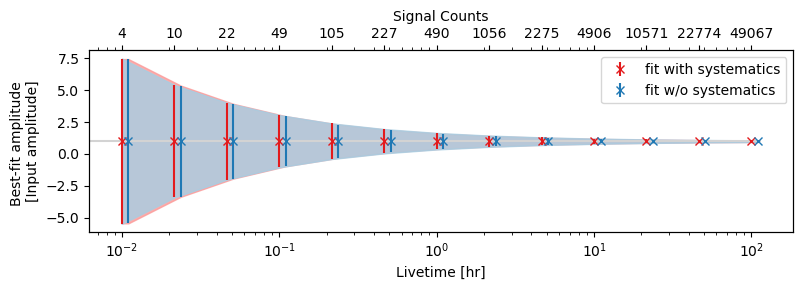

In [16]:
inputvalues = {"amplitude":datasets_input[0].models[0].parameters['amplitude'].value,
               "index1":datasets_input[0].models[0].parameters['index1'].value ,
               "index2":datasets_input[0].models[0].parameters['index2'].value,
              "ebreak": datasets_input[0].models[0].parameters['ebreak'].value}
def plotting(parname = "amplitude"):
    fig = plt.figure(figsize  = (8,3))
    inputvalue = inputvalues[parname]
    
    errs = []
    errs_N = []
    livetimes_ext = np.array(livetimes).copy(); livetimes_ext2 = np.array(livetimes).copy(); 
    livetimes_ext[-1] *=1.1;
    livetimes_ext2[0:,] *=1.1; 
    livetimes_ext2 = np.insert(livetimes_ext2, 0, values =  livetimes_ext2[0]* 0.9)


    for i, d in enumerate(datasets_N):
        par = datasets[i].models[0].parameters[parname]
        val, err = par.value, par.error
        errs.append( err/ inputvalue)
        plt.errorbar(livetimes[i], val/ inputvalue, yerr = err/ inputvalue,  fmt='x', 
                     color = awo[0])

        par = d.models[0].parameters[parname]
        val, err = par.value, par.error
        errs_N.append( err/ inputvalue)
        plt.errorbar( 1.1* livetimes[i] , val/ inputvalue, yerr = err/ inputvalue,  fmt='x', 
                     color = aw[0])

    

    errs_N = np.insert(errs_N, 0, values =  errs_N[0])
    plt.fill_between(  livetimes_ext2, 1- np.array(errs_N), 1+np.array(errs_N) 
                     ,color = awo[1], alpha = 0.8, label = '')
    plt.fill_between( livetimes_ext, 1- np.array(errs), 1+np.array(errs)
                     ,color = aw[1], alpha = 0.8, label = '')

    plt.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = awo[0],
                 label = 'fit with systematics')
    plt.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = aw[0], 
                 label = 'fit w/o systematics')
    ax1 = plt.gca()
    xlim = ax1.get_xlim()
    plt.hlines(1, xlim[0], xlim[1], color = 'lightgrey')
    #plt.title("Best Fit Amplitude")
    plt.legend()
    plt.xscale('log')
    plt.xlabel("Livetime [hr]")
    plt.ylabel(f"Best-fit {parname} \n[Input {parname}]")

    ax2 = ax1.twiny()
    ax2.set_xscale("log")
    npred = [d.npred_signal().data.sum() for d in datasets]
    
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(livetimes)
    clabels = [ f'{int(c)}' for c in npred]
    ax2.set_xticklabels(clabels)
    ax2.set_xlabel(r"Signal Counts")
    plt.tight_layout()
    return fig

fig = plotting(parname = "amplitude")
fig.savefig(f'../{folder}/plots/{nbidx}_best_fit_vs_livetime_amplitude.svg')
fig.savefig(f'../{folder}/plots/{nbidx}_best_fit_vs_livetime_amplitude.pdf')
fig.savefig(f'../{folder}/plots/{nbidx}_best_fit_vs_livetime_amplitude.png')

/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1183: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1184: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


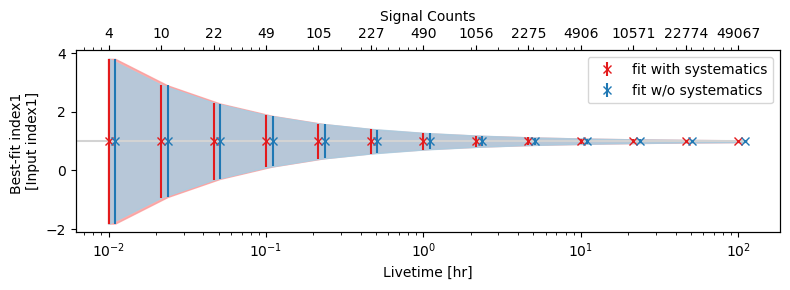

In [13]:
fig = plotting(parname = "index1")
fig.savefig(f'../{folder}/plots/{nbidx}_best_fit_vs_livetime_index.svg')
fig.savefig(f'../{folder}/plots/{nbidx}_best_fit_vs_livetime_index.pdf')
fig.savefig(f'../{folder}/plots/{nbidx}_best_fit_vs_livetime_index.png')

/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1183: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1184: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


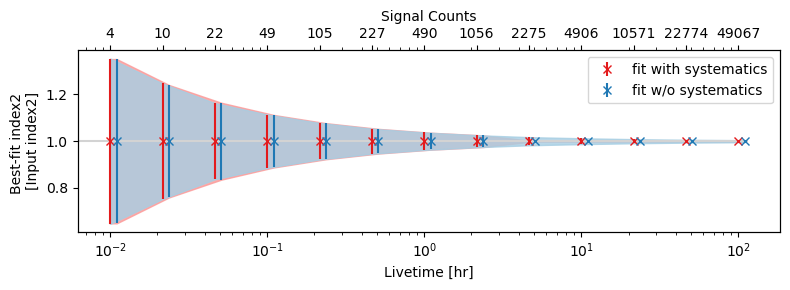

In [31]:
fig = plotting(parname = "index2")
fig.savefig(f'../{folder}/plots/{nbidx}_best_fit_vs_livetime_index2.svg')
fig.savefig(f'../{folder}/plots/{nbidx}_best_fit_vs_livetime_index2.pdf')
fig.savefig(f'../{folder}/plots/{nbidx}_best_fit_vs_livetime_index2.png')

/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1183: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1184: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


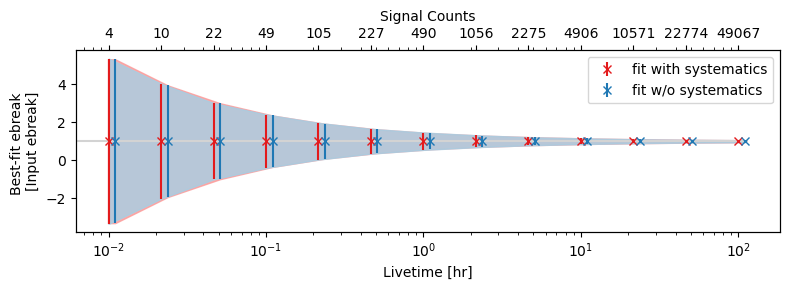

In [17]:
fig = plotting(parname = "ebreak")
fig.savefig(f'../{folder}/plots/{nbidx}_best_fit_vs_livetime_ebreak.svg')
fig.savefig(f'../{folder}/plots/{nbidx}_best_fit_vs_livetime_ebreak.pdf')
fig.savefig(f'../{folder}/plots/{nbidx}_best_fit_vs_livetime_ebreak.png')

In [20]:
print(datasets[6].models)

DatasetModels

Component 0: SkyModel

  Name                      : Crabbreak
  Datasets names            : None
  Spectral model type       : SmoothBrokenPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index1                        :      1.610   +/-    0.46             
    index2                        :      2.950   +/-    0.11             
    amplitude                     :   3.35e-10   +/- 2.2e-10 1 / (cm2 s TeV)
    ebreak                        :      0.330   +/-    0.15 TeV         
    reference             (frozen):      1.000       TeV         
    beta                  (frozen):      1.730                   
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         




In [21]:
print(datasets_N[6].models)

DatasetModels

Component 0: SkyModel

  Name                      : Kz_mWAtp
  Datasets names            : None
  Spectral model type       : SmoothBrokenPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index1                        :      1.612   +/-    0.42             
    index2                        :      2.953   +/-    0.11             
    amplitude                     :   3.35e-10   +/- 2.0e-10 1 / (cm2 s TeV)
    ebreak                        :      0.330   +/-    0.14 TeV         
    reference             (frozen):      1.000       TeV         
    beta                  (frozen):      1.730                   
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : 7gKIXq-i-bkg
  Datasets names            : ['7gKIXq-i']
  Spectral model type       : Po

## RND Fluxpoints

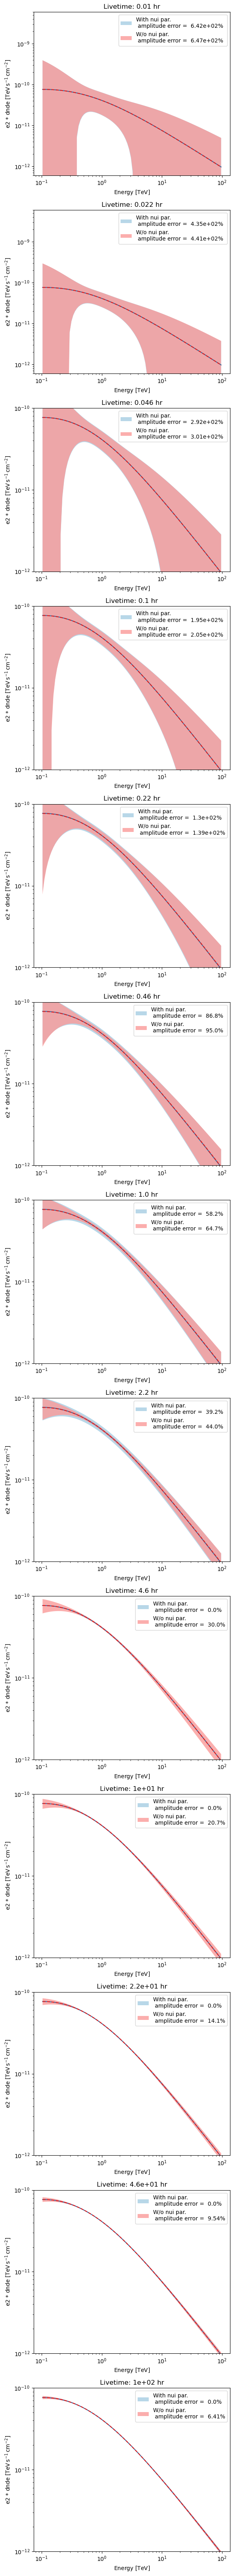

In [33]:
def plot_spectra():
    fig,axs = plt.subplots(len(datasets), 1, figsize = (6, 5 * len(datasets)))
    axs= axs.flatten()
    energy_power = 2
    for i, d in enumerate(datasets):
        ax = axs[i]
        live = livetimes[i]
        dataset = datasets[i]
        dataset_N = datasets_N[i]

        dataset_N.models[0].spectral_model.plot((0.1, 100) *u.TeV, energy_power = energy_power,
                                                     color = aw[0], ax = ax)    
        par = dataset_N.models[0].parameters['amplitude']
        per = par.error /par.value
        dataset_N.models[0].spectral_model.plot_error((0.1, 100) *u.TeV,energy_power = energy_power, ax = ax, 
                                                   facecolor= aw[1], alpha = 0.8, 
                                                     label = f'With nui par.\n amplitude error =  {per*100:.3}% ')
        dataset.models[0].spectral_model.plot((0.1, 100) *u.TeV,energy_power = energy_power, ax = ax, 
                                                   color= awo[0], linestyle = 'dashed')
        par = dataset.models[0].parameters['amplitude']
        per = par.error /par.value
        dataset.models[0].spectral_model.plot_error((0.1, 100) *u.TeV,energy_power = energy_power, ax = ax, 
                                                   facecolor= awo[1], alpha = 0.8,
                                                   label = f'W/o nui par.\n amplitude error =  {per*100:.3}%')
        ax.set_title(f"Livetime: {float(live):.2} hr")
        ax.set_ylim(1e-12, 1e-10)

        if i <2:
            ax.set_ylim(6e-13, 6e-9)
            
        
        #if live in lives:
        #    idx = np.where(live == lives)[0][-1]
        #    fpd_Ns[idx].data.plot(ax = ax, energy_power = energy_power, color = purple[0],
        ##                         label = "Example fluxpoint with nui par.")
        #    fpd_s[idx].data.plot(ax = ax, energy_power = energy_power, color = orange[0],
        #                        label = "Example fluxpoint w/o nui par.")
        ax.legend()
    plt.tight_layout()
    return fig
        
fig = plot_spectra()
fig.savefig(f'../{folder}/plots/{nbidx}_spectra_with_rnd_fp.pdf')

In [ ]:
live = lives[0]
energy_power = 2
if live in lives:
    idx = np.where(live == lives)[0][-1]
    fpd_Ns[idx].data.plot( energy_power = energy_power, color = purple[0],
                         label = "Example fluxpoint with nui par.")
    fpd_s[idx].data.plot( energy_power = energy_power, color = orange[0],
                         label = "Example fluxpoint with nui par.")

In [ ]:
fpd_s[idx].models.parameters.to_table()

In [ ]:
fpd_s[idx].data.dnde_ref.flatten()

In [ ]:
fpd_Ns[idx].models.parameters.to_table()

In [ ]:
fpd_Ns[idx].data.dnde_ref.flatten()

In [ ]:
par_names = ['index', 'amplitude', 'lambda_', 'bias', 'resolution', 'norm' , 
            'tilt']
names =  ['index', 'amplitude',  
        'bkg norm', 'bkg tilt',
          'bias', 'resolution',
          'eff. area norm' , 
            'eff. area tilt']
for i in range(len(livetimes)):

    #datasets_N[i].models.read_covariance("data", f"8_model_nui_livetime_{livetimes[i]}_covariance.dat", format="ascii.fixed_width")
    parameters = Parameters([_ for _ in datasets_N[i].models.parameters if _.name in par_names])
    cov_par = datasets_N[i].models.covariance.get_subcovariance(parameters)
    ax = cov_par.plot_correlation()
    ax.set_title(str(livetimes[i]) + " hr")
    fig = plt.gcf()
    fig.savefig(f'../{folder}/plots/{nbidx}_covmatrix_livetime_{livetimes[i]}.svg")
    fig.savefig(f'../{folder}/plots/{nbidx}_covmatrix_livetime_{livetimes[i]}.pdf")
    
